<a href="https://colab.research.google.com/github/mratanusarkar/Learning-DeepLearning/blob/main/Neural%20Networks%20-%20Zero%20to%20Hero/building%20micrograd/05.%20expression%20graph%20-%20a%20neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing code from the previous notebook

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# updated micrograd Value class with a sample activation function: tanh

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children) # previous node
        self._op = _op              # the operation that produced this node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out


In [3]:
# updated visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# Let's build a neuron

In [4]:
# previously we have tried and experimented with simple mathematical expressions
# now let's try to build a more complex and useful expression that will be helpful in the context of deep learning
# let's start with a neuron

Ideally we would like to build a neural network that looks like this image below.

We have multiple neurons (multi-layer perceptrons) that are connected to each other in layers: input layer, hidden layers and output layer

![neural_net2.jpeg](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [5]:
# Let's take a look at a neuron closely:

Biologically neurons are very complicated. Here is how a biological neuron looks like:

![neuron.png](https://cs231n.github.io/assets/nn1/neuron.png)

People in machine learning and deep learning community tried to model neurons throughout time.
Here is a simple mathematical model of the biological neuron:

We have multiple inputs (`x_i`) coming in, which passes in through the dendrites.
Each dendrite has it's own weights (`w_i`), so the signal coming in the cell body reacts multiplicatively, and the net input signal is (`w_i * x_i`).
Now, inside the cell body, all the input signal get's summed and there is a bias term (`b`), and the net signal strength becomes: `sum(w_i * x_i) + b`
which passes through an activation function `f` (that introduces non-linearity into the picture).
Finally the neuron fires or outputs, and the signal strength can be mathematically represented as: `out = f(sum(w_i * x_i) + b)`

![neuron_model.jpeg](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

In [6]:
# there are many activation functions that we can use
# some popular ones are:
# sigmoid, tanh, ReLU, ...etc

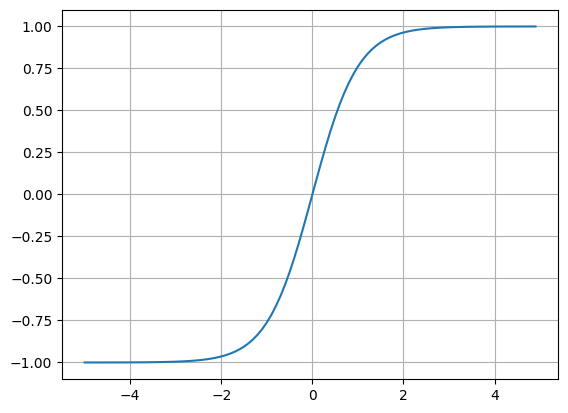

In [7]:
# let's take a look at tanh
x_axis = np.arange(-5, 5, 0.1)
y_axis = np.tanh(x_axis)
plt.plot(x_axis, y_axis)
plt.grid()

# Building an Expression for a Neuron and Forward Pass

In [8]:
# let's start writing an expression for our neuron with two inputs: x1 and x2

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')    # setting a weird value, as it will help in calculation down the line!

# dendrites of the neuron (inputs weighted)
den1 = x1 * w1;     den1.label='den1'
den2 = x2 * w2;     den2.label='den2'

# sum of dendrite signals inside cell body
sum = den1 + den2;  sum.label='sum'

# bias gets added inside the body
body = sum + b;     body.label='body'

# the net signal passes through an activation function to give output
out = body.tanh();  out.label='out'

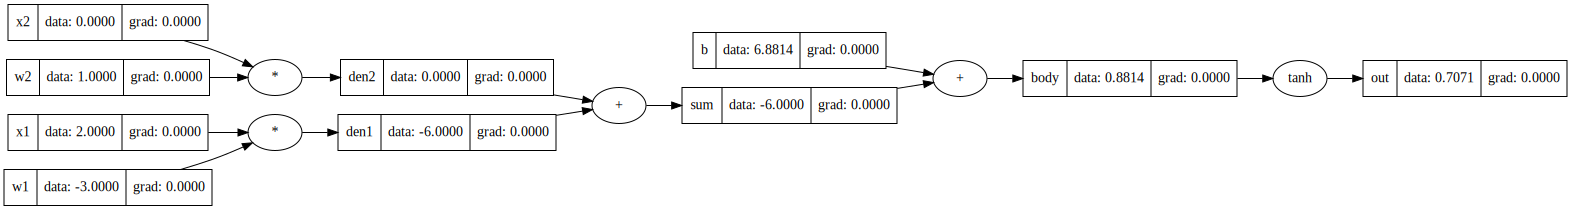

In [9]:
draw_dot(out)

In [10]:
# and that's it! we have successfully modeled a neuron!

# Manual Backpropagation

In [11]:
# we already know the drill from previous notebooks
# so let's just fill in the grads without any derivations and minimal explainations this time

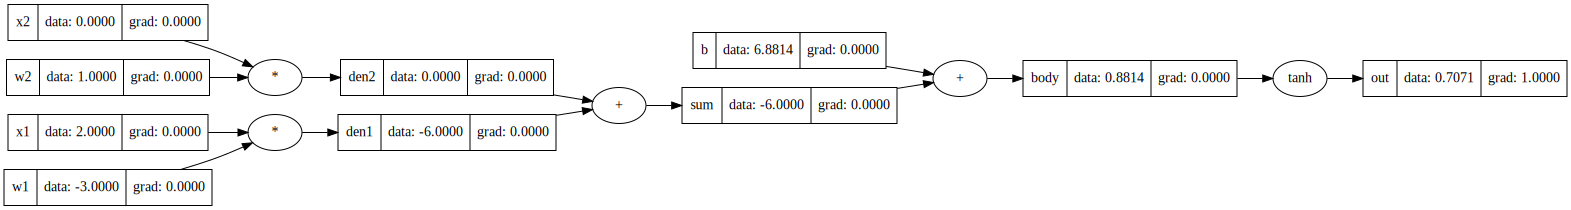

In [12]:
# we know that the output grad is 1.0 (do/do = 1)
out.grad = 1.0
draw_dot(out)

In [13]:
# now to backpropagate through tanh, we have to know the local derivative of tanh
# the current expression: out = tanh(body)

# now, we can again use calculus formulas/first principles to derive the same,
# or just take a shortcut from wiki: https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives

# if f(x) = tanh(x), then
# f'(x) = 1 - tanh(x)^2

In [14]:
# local derivative of tanh = 1 - tanh(x)**2, 
# and we already know the value of tanh = the data in out!
# so, grad of body:
print(out.grad - out.data **2)  # which is close to 0.5, and our weird value of b is the reason we got a clean value :p

0.4999999999999999


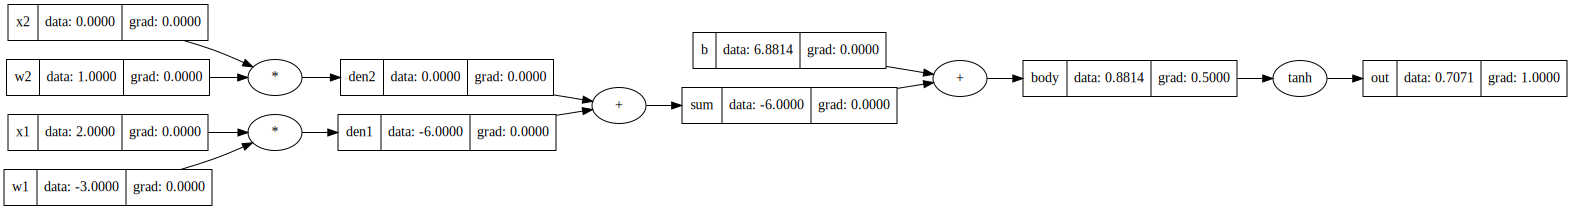

In [15]:
# let's update the same
body.grad = 0.5
draw_dot(out)

In [16]:
# let's now backpropagate the remaining grads to reach the input nodes, 
# and they should be easy from the rules we had established in the last notebook!

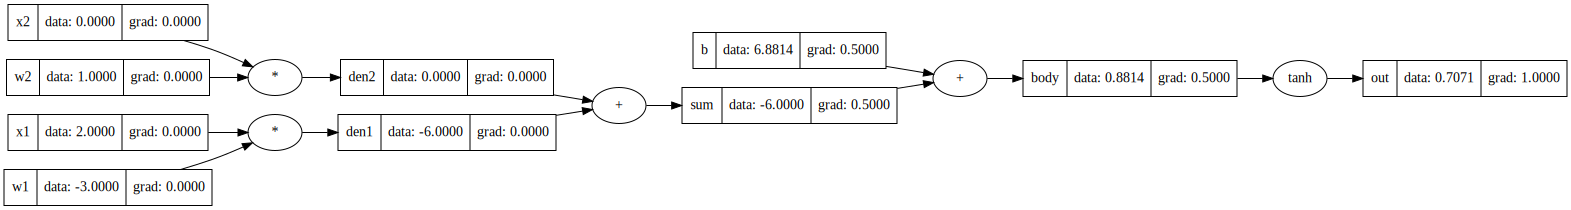

In [17]:
# for (+): local derivative is 1.0, and we just direct the grads inward
b.grad = 1.0 * body.grad
sum.grad = 1.0 * body.grad

draw_dot(out)

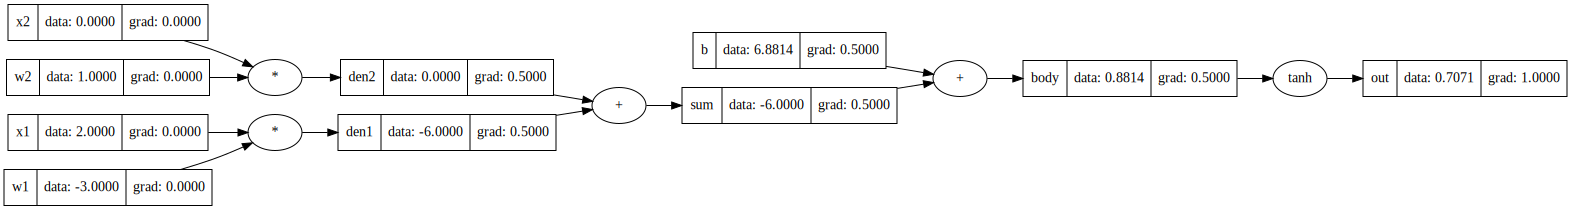

In [18]:
# again a (+), same drill
den1.grad = 1.0 * sum.grad
den2.grad = 1.0 * sum.grad

draw_dot(out)

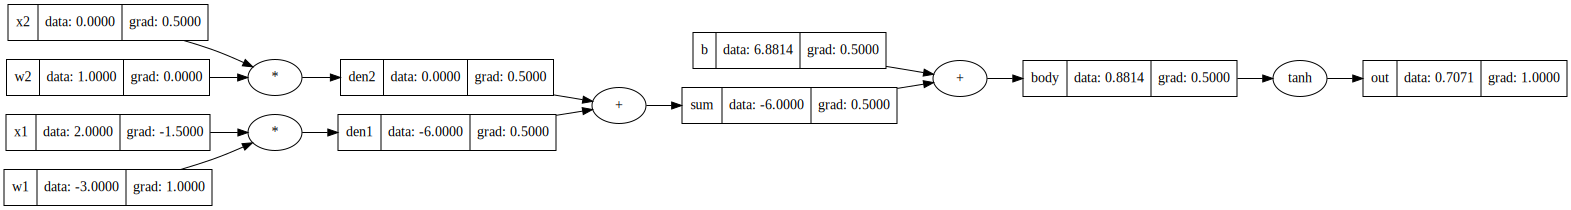

In [19]:
# for (*): local derivative is swapping the child nodes data, and we just multiply with incoming grads inward
x1.grad = w1.data * den1.grad
w1.grad = x1.data * den1.grad

x2.grad = w2.data * den2.grad
w2.grad = x2.data * den2.grad

draw_dot(out)

In [20]:
# and we are done!

In [21]:
# one interesting thing to note here is:
# notice how the grad for w2 came out to be 0.0, because x2 was 0.0

# it because how (*) works... think about it
# grad/derivative tells us the influence of a value causing change in the final output

# so, in this context, how nudging w1 will change the out
# and we see it is not changing, as x2 = 0.0, and that's how (*) works! 
# and because out is not changing, there is no derivative, and hence grad = 0.0. it's like a dead node!